# Time Series Linear Model

In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import sys
sys.path.append('..')

In [61]:
import statslib as stb

import statsmodels.api as sm

import pandas as pd
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt

figsize = (8*1.6, 8)

In [62]:
import warnings
warnings.filterwarnings("ignore")

# Data Set

In [63]:
stb.datasets.uschange.df.head()

,Consumption,Income,Production,Savings,Unemployment
date,,,,,
1970-03-31,0.615986,0.972261,-2.452700,4.810312,0.9
1970-06-30,0.460376,1.169085,-0.551525,7.287992,0.5
1970-09-30,0.876791,1.553271,-0.358708,7.289013,0.5
1970-12-31,-0.274245,-0.255272,-2.185455,0.985230,0.7
1971-03-31,1.897371,1.987154,1.909734,3.657771,-0.1


In [64]:
y = stb.datasets.uschange.df.Consumption

In [65]:
X = stb.datasets.uschange.df.drop('Consumption', axis=1)

# Design Matrix

In [66]:
DM = stb.DesignMatrix(y, X)

,Consumption,Income,Production,Savings,Unemployment
count,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.746471,0.717627,0.508060,1.222319,0.007487
std,0.655349,0.931356,1.544829,13.667434,0.375238
min,-2.274110,-4.265250,-6.851039,-68.788267,-0.900000
25%,0.419777,0.337765,0.055683,-4.217823,-0.200000
50%,0.772144,0.723721,0.657928,1.280017,0.000000
75%,1.089752,1.165022,1.305724,6.650723,0.100000
max,2.318295,4.536510,4.149574,50.757962,1.400000


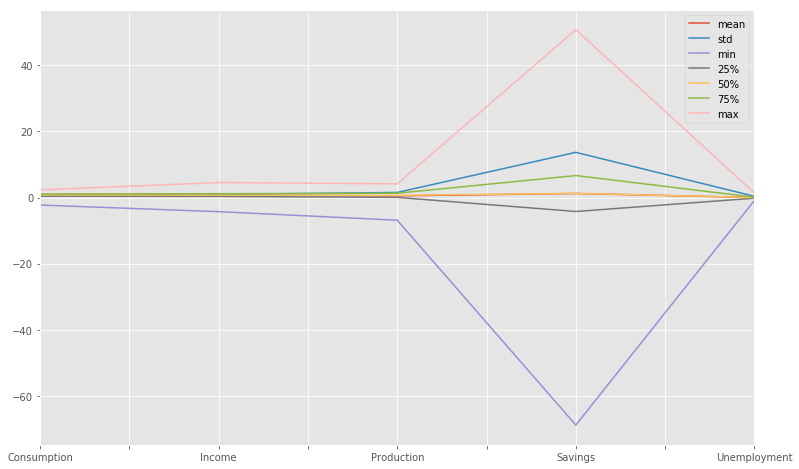

In [67]:
DM.describe()

In [68]:
DM.names

{'v': 'Consumption',
 'g1': 'Income',
 'g2': 'Production',
 'g3': 'Savings',
 'g4': 'Unemployment',
 'const': 'const'}

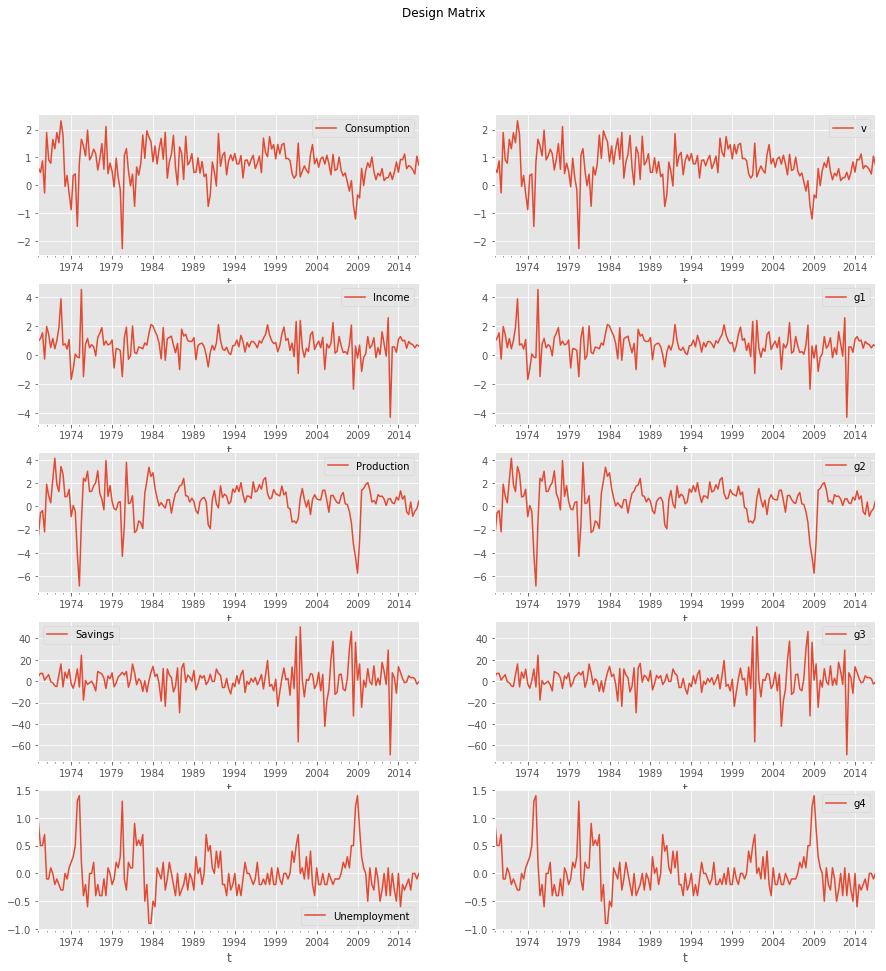

In [69]:
DM.plot()

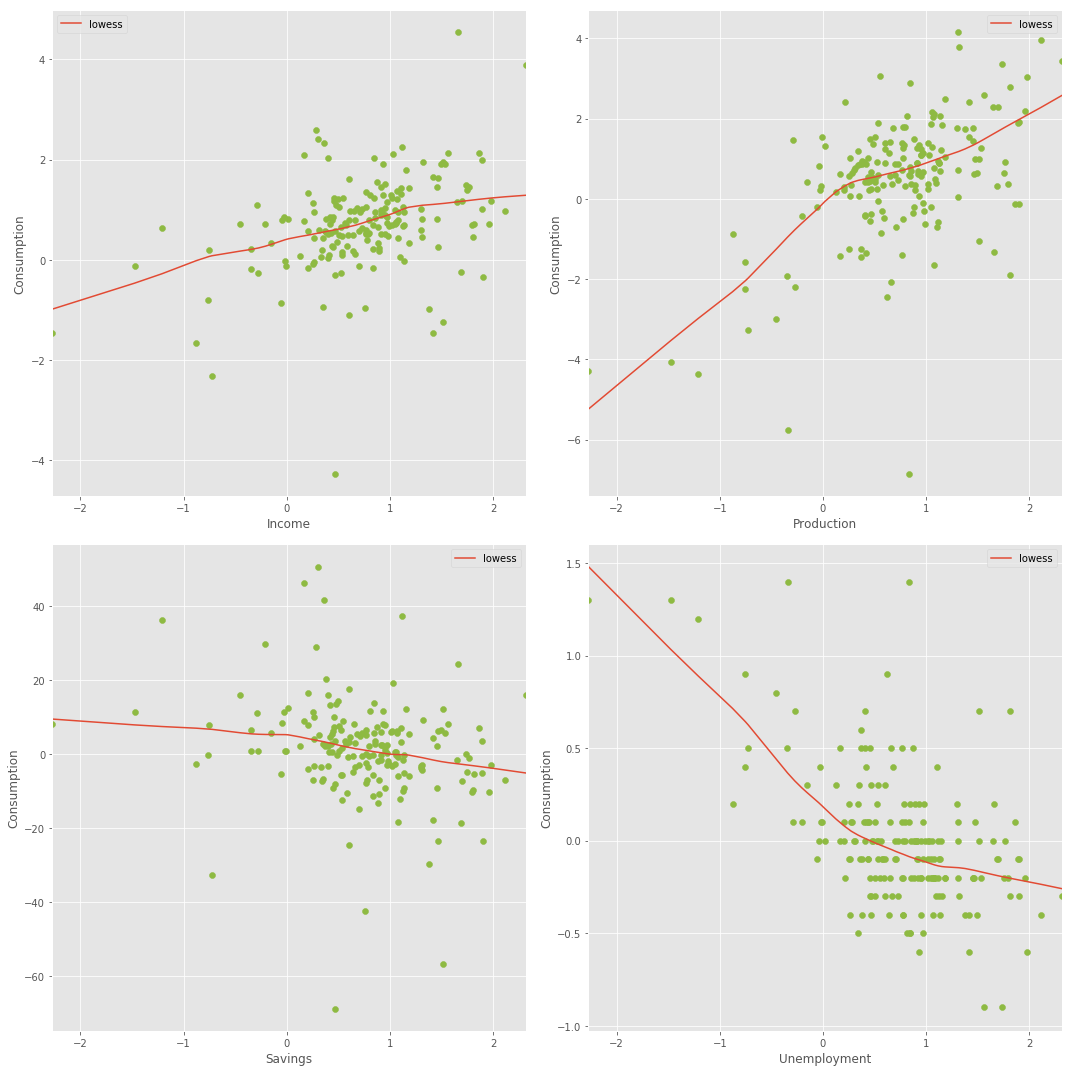

In [70]:
DM.plot_scatter_lowess()

# Grid Search

When fittind models, it is possible to increase the likelihood by adding parameters, but doing so may resut in overfitting. Both AIC, AICc and BIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC

## Information criterions

Likelihood function:
$$
L = p (x | \hat{\theta}, Model)
$$

### Akaike information criterion
$$
AIC = 2k - 2\ln(L)
$$


### Akaike with correction for small sample sizes

$$
AICc = AIC + \dfrac{2k^2 + 2k}{n-k-1}
$$

$ \\ $

*Hirotugu Akaike 1971*

### Bayesian information criterion

$$
BIC = k \ln(n) - 2\ln(L)
$$


where 
* $L$ - is maximum of the likelihood function
* $k$ - number of parameters estimated
* $n$ - number of data points

In [71]:
from itertools import product

from functools import partial
powerset = partial(stb.utils.common.powerset, skip_empty_set=True)

nms = [DM._inv_names.get(k) for k in DM.endog_names]
grid = product(['const'], powerset(nms))
results = []
for elem in grid:
    try:
        c, v = elem
        nm = [c] + list(v)
        gc = stb.GeneralCalibrator(sm.OLS, dict())
        nDM = deepcopy(DM)
        nDM.gX = nDM.gX[nm]
        gm = stb.GeneralModel(gc, nDM)
        gm.fit(range(DM.dm.shape[0]))
        results.append([elem, gm.fitted.bic, nm])
    except Exception as e:
        print(e.args[0])
        continue
pd.DataFrame(results, columns=['elem', 'metric', 'config']).sort_values(
    by=['metric'], ascending=True)[['config', 'metric']]

,config,metric
12,"[const, g1, g3, g4]",133.513313
10,"[const, g1, g2, g3]",134.140518
14,"[const, g1, g2, g3, g4]",135.540525
5,"[const, g1, g3]",149.649140
11,"[const, g1, g2, g4]",298.443878
6,"[const, g1, g4]",300.448641
4,"[const, g1, g2]",302.250964
13,"[const, g2, g3, g4]",307.233988
7,"[const, g2, g3]",309.434068
8,"[const, g2, g4]",312.078289


In [72]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6)
splits = [(train_idx, test_idx) for train_idx, test_idx in tscv.split(DM.dm.index)]

In [73]:
metric = stb.metrics.mean_absolute_percentage_error

# General Linear Regression

CV_error: 0.8920 +/- 0.4282


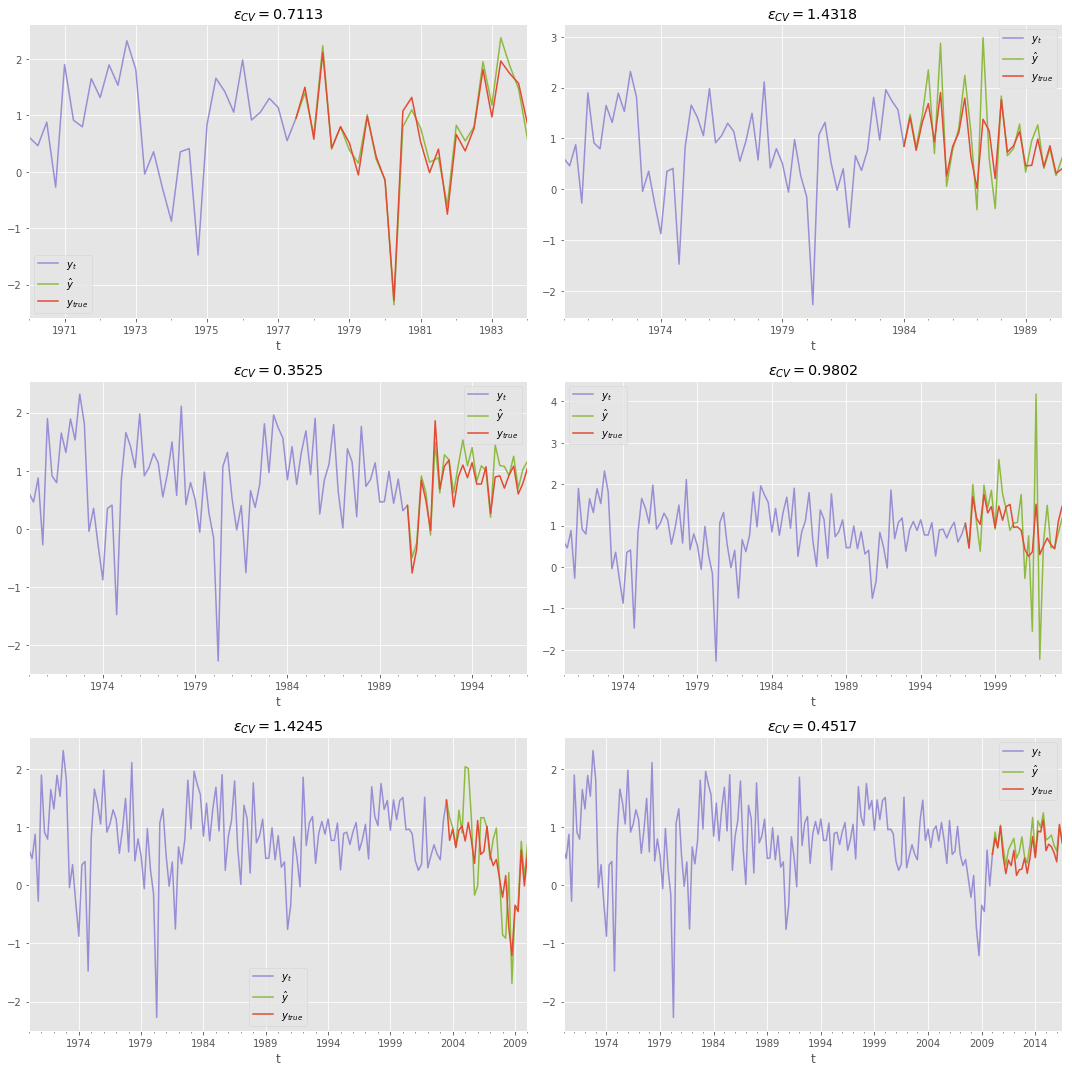

In [74]:
specification = ['const', 'g1', 'g3', 'g4']

gc = stb.GeneralCalibrator(sm.OLS, dict())
nDM = deepcopy(DM)

nDM.gX = nDM.gX[specification]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run()

# Robust Linear Regression

CV_error: 0.8973 +/- 0.4090


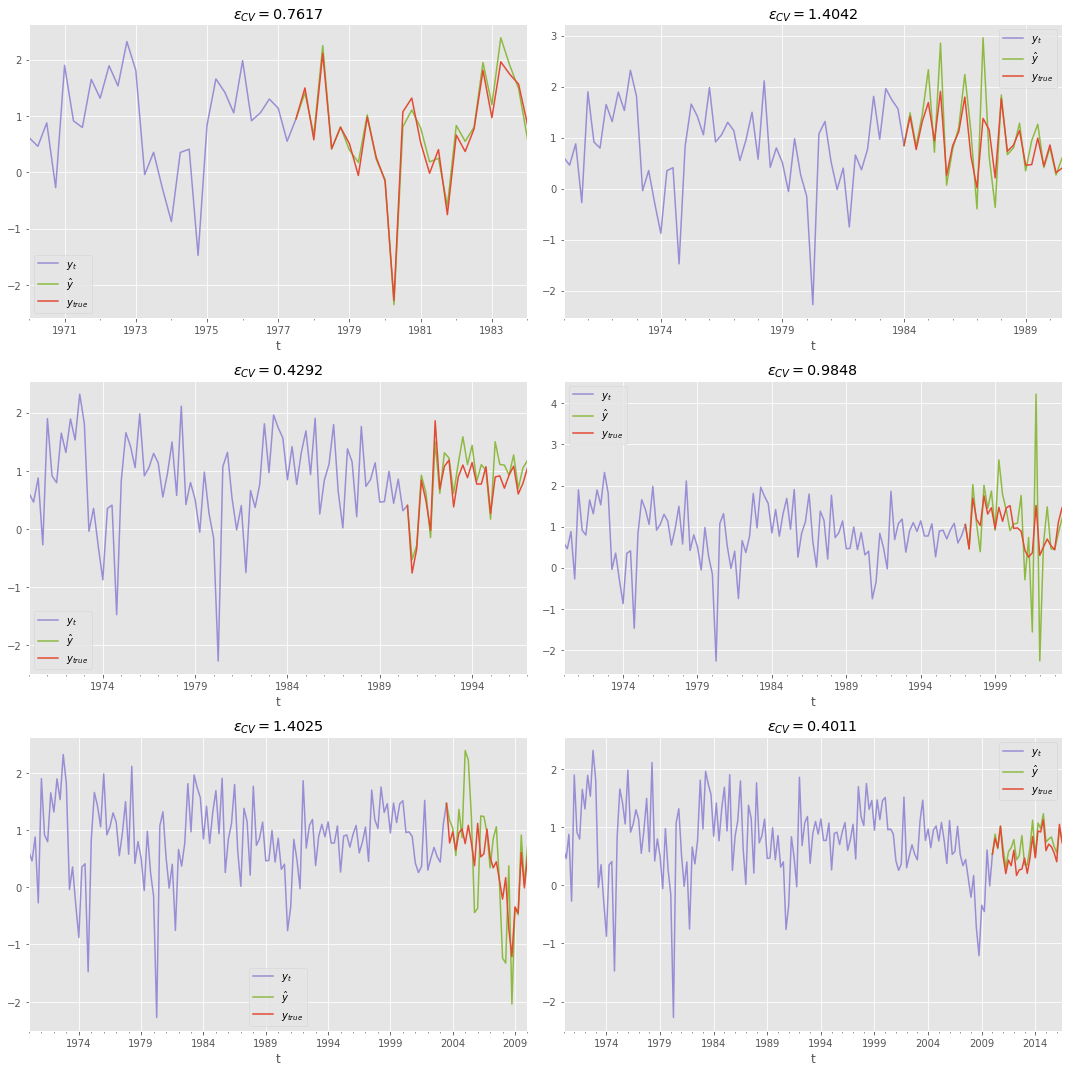

In [75]:
specification = ['const', 'g1', 'g3', 'g4']

gc = stb.GeneralCalibrator(sm.RLM, dict())
nDM = deepcopy(DM)

nDM.gX = nDM.gX[specification]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run()

# Final Model

In [76]:
gc = stb.GeneralCalibrator(sm.OLS, dict())

nDM = deepcopy(DM)

nDM.gX = nDM.gX[specification]

gm = stb.GeneralModel(gc, nDM)

gm.fit(range(DM.n))

gm.forecast(range(DM.n))

print(gm.fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      v   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     182.7
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           8.43e-55
Time:                        09:18:20   Log-Likelihood:                -56.294
No. Observations:                 187   AIC:                             120.6
Df Residuals:                     183   BIC:                             133.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2810      0.037      7.677      0.0

# Diagnostics

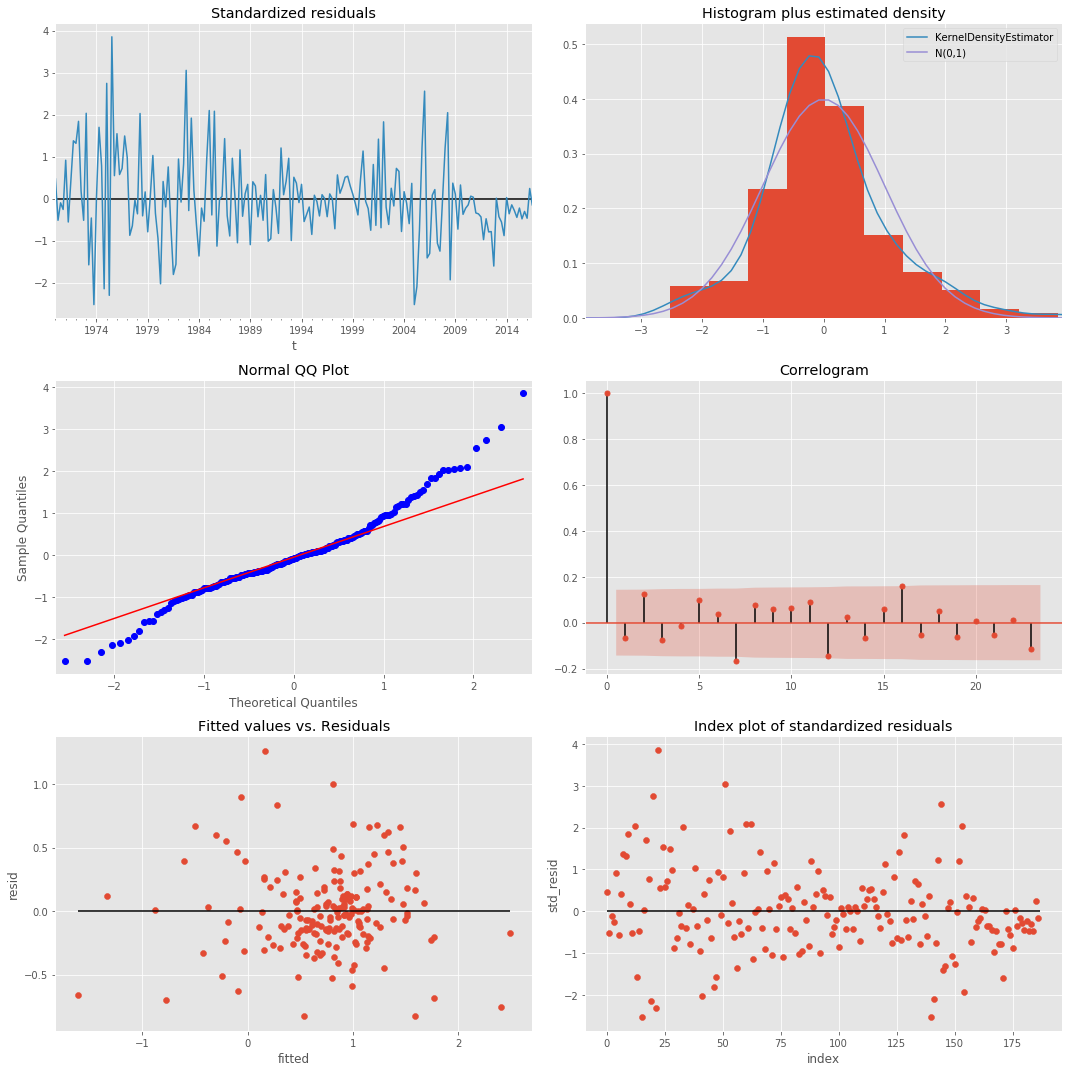

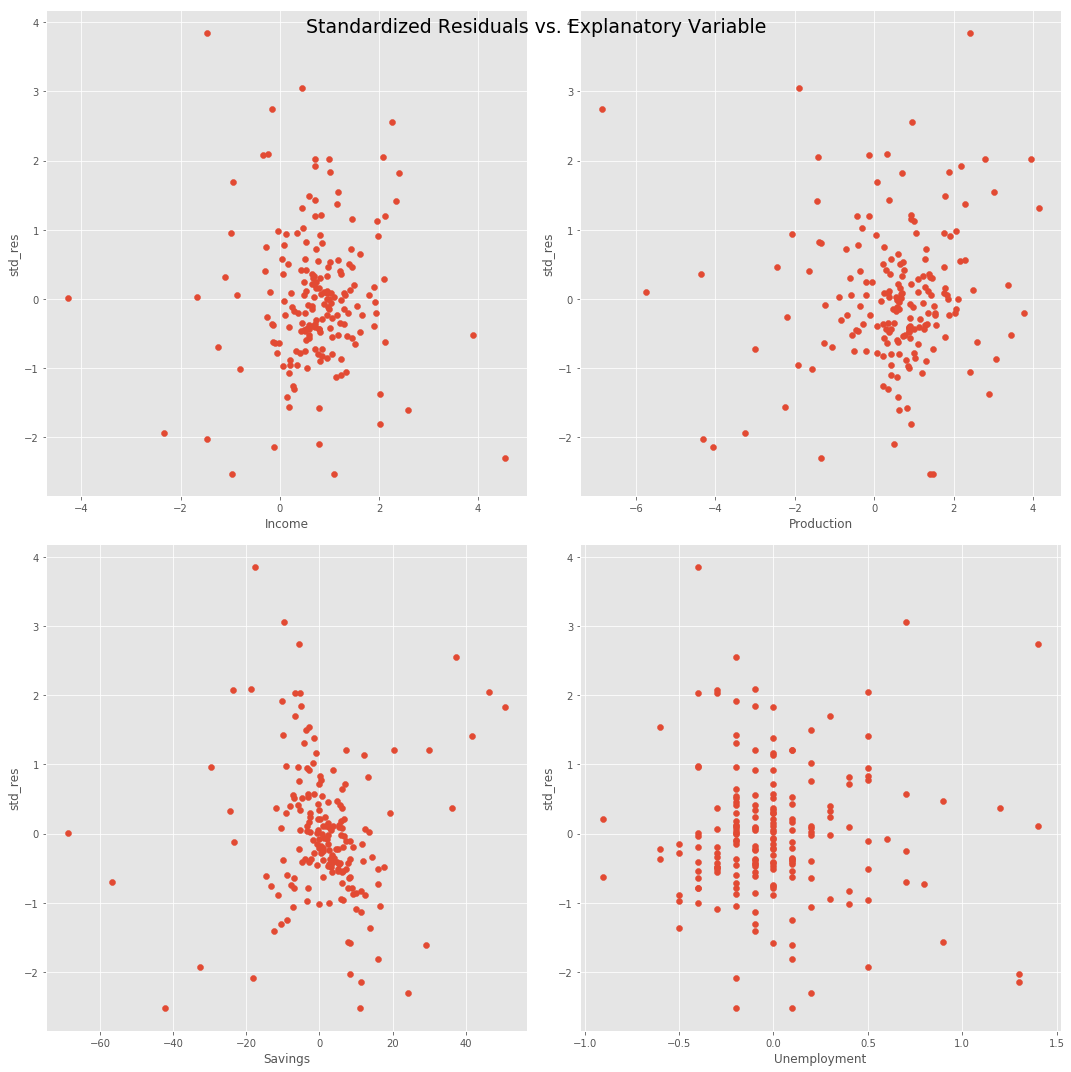

In [77]:
gm.plot_diagnostics()

**Jarque Bera test for 3d and 4th moment matching to the Normal one:**

In [78]:
stb.stat_tests.test_jarque_bera(gm.std_residuals)

H0: sample datasets have the skewness and kurtosis matching a normal distribution

Results of Jarque Bera Test:
Test Statistic    24.474743
p-value            0.000005
skew               0.536006
kurtosis           4.411360
dtype: float64

p-value 0.0000 is less alpha 0.01 => Reject H0


**Breusch Pagan Test for homoscedasticity**

In [79]:
stb.stat_tests.test_breusch_pagan(gm.residuals, gm.fitted.model.exog)

H0: series is homoskedastic

Results of BP Test:
Lagrange multiplier statistic    4.826931
p-value                          0.184918
f-value                          1.616281
f p-value                        0.187142
dtype: float64

Can NOT reject H0


**Influence DataFrame**

In [80]:
infl = gm.fitted.get_influence()

df_infl = infl.summary_frame()

df_infl[:5]

,dfb_const,dfb_g1,dfb_g3,dfb_g4,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
t,,,,,,,,,,
1970-03-31,-0.012527,0.046470,-0.035508,0.095841,0.002648,0.474221,0.044973,0.102908,0.473214,0.102690
1970-06-30,0.001849,-0.034219,0.018753,-0.058611,0.001318,-0.515759,0.019430,-0.072601,-0.514722,-0.072455
1970-09-30,0.004058,-0.011676,0.007465,-0.013739,0.000074,-0.101240,0.028095,-0.017213,-0.100966,-0.017166
1970-12-31,-0.022841,0.013898,-0.007863,-0.025836,0.000462,-0.259247,0.026737,-0.042969,-0.258585,-0.042859
1971-03-31,-0.048182,0.123287,-0.084964,0.036019,0.005096,0.915063,0.023765,0.142773,0.914654,0.142709


**Leverage vs Studentized Residuals and Cook's distance**

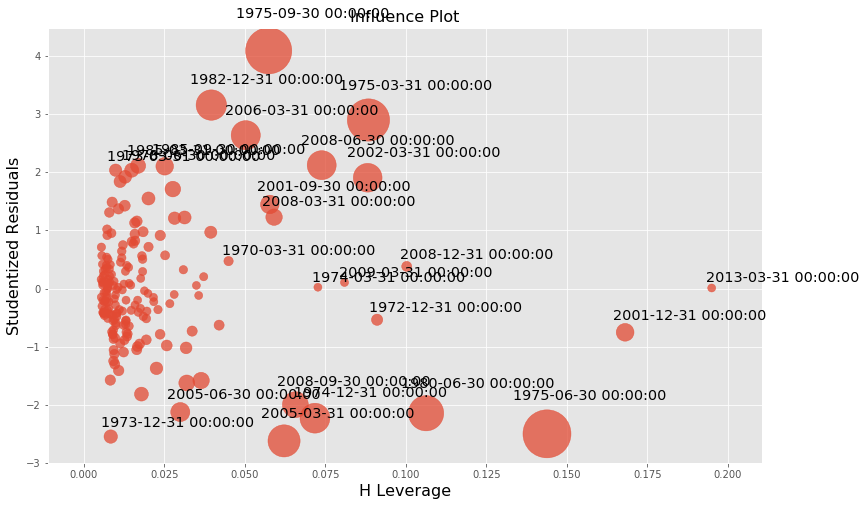

In [81]:
with mpl.rc_context():
    mpl.rc("figure", figsize=figsize)
    sm.graphics.influence_plot(gm.fitted)
    plt.show()